In [ ]:
!pip install bert-for-tf2

     |████████████████████████████████| 51kB 5.2MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30539 sha256=72c2d25c8c385b340f0bd900aae16223e811b9dc595e77bc404bbdfde1010e5f
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=3fe0c1279902b49ca66da5acfdaed6a305a1dcb966811189dde3e8d4e2dc8c70
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=7d71f41cf64857c31e3441fbdd4f09a720dc8c44f4a9346fc0222d5820a25c65
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 23.9MB/s 
     |████████████████████████████████| 890kB 53.6MB/s 
     |████████████████████████████████| 2.9MB 38.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3a963837dffeac8734ec3b79d9139251e0439c3af99dc1a9d884e58d2947846f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore")
import datetime
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import scipy
from scipy import sparse 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/sentiment analysis") 

### Loading the data after augmentation

In [ ]:
final_df=pd.read_csv("final_df.csv")

In [ ]:
final_df=final_df.sort_values(by="dates")

In [ ]:
final_df["y"].value_counts()

1    31629
0     6459
Name: y, dtype: int64

In [ ]:
final_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'dates', 'reviews',
       'reviews.doRecommend', 'y', 'polarity'],
      dtype='object')

In [ ]:
final_df=final_df.drop(["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1"],axis=1)

Since we need to do time based split, we use numpy.split() and spit first 67% data into train and remaining 33% as test data

In [ ]:
 
train, test= np.split(final_df, [int(.67 *len(final_df))])

In [ ]:
print(train.shape)
train

(25518, 5)


,dates,reviews,reviews.doRecommend,y,polarity
0,2017-03-04 10:47:59.786,great great great great kids play easy monitor...,1,1,0.588889
33783,2017-03-04 10:47:59.786,not decide needs not not needs not meet needs ...,0,0,-0.250000
7,2017-03-04 10:47:59.786,great buy price great buy price great buy pric...,1,1,0.572727
6,2017-03-04 10:47:59.786,excellent learning device son excellent learni...,1,1,0.700000
5,2017-03-04 10:47:59.786,great toddler great toddler great toddler grea...,1,1,0.363750
...,...,...,...,...,...
22037,2017-08-27 00:00:00.000,fun product fun product fun product fun produc...,1,1,0.537500
22038,2017-08-27 00:00:00.000,one one one bought vacation electronics music ...,1,1,-0.150000
22039,2017-08-27 00:00:00.000,great tablet great tablet great tablet kindle ...,1,1,0.733333
22040,2017-08-27 00:00:00.000,great gift grandmother great gift grandmother ...,1,1,0.708333


In [ ]:
l=[]
for i in train["reviews"].values:
  l.append(len(i.split()))
print(np.mean(l))
print(np.percentile(l,90))
print(np.percentile(l,99))
print(np.max(l))

21.499137863468924
37.0
68.0
96


We will conisider 70 as the maximum length for reviews

In [ ]:

print(test.shape)
test.tail()

(12570, 5)


,dates,reviews,reviews.doRecommend,y,polarity
33777,2018-04-28 00:00:00.000,not satisfied sound loses bluetooth connec...,1,0,-0.050000
33776,2018-04-28 00:00:00.000,perfect speaker house perfect speaker house pe...,1,1,0.950000
33775,2018-04-28 00:00:00.000,nice nice nice loud enough small gatherings re...,1,1,0.275000
33781,2018-04-28 00:00:00.000,portable portable portable wanted portable spe...,0,1,0.320476
38087,2018-04-28 00:00:00.000,hands free hands free hands free echo not upda...,1,0,0.308333


Now the features we consider for modeling are: reviews, reviews.dorecommend, polarity and the y values

### Featurization of text data using the bert model

#### Loading the bert model


In [ ]:
import tensorflow as tf
import keras
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import transformers
import bert
from bert import bert_tokenization

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length is 70
max_seq_length = 70

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")


#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
#pooled output is the 768 dim vector corresponing to cls token
#sequnece output is a vector(None,70, 768)
#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


INFO:absl:resolver HttpCompressedFileResolver does not support the provided handle.
INFO:absl:resolver GcsCompressedFileResolver does not support the provided handle.


In [ ]:
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 70)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 70)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
#getting the vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer=bert_tokenization.FullTokenizer(vocab_file,do_lower_case=True)

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# maximum number of tokens is 70(We already given this to BERT layer above) so shape is (None, 70)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 70) save those in X_train_mask, X_test_mask
# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 70)
# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment


X_train_tokens=[]
X_train_mask=[]
X_train_segment=[]
for text in (train["reviews"]):
  # add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 
  tokens= ["[CLS]",*tokenizer.tokenize(text)[:68],"[SEP]"]
  if len(tokenizer.tokenize(text))<68:
    X_train_mask.append(np.array([1]*len(tokens)+[0]*(70-len(tokens))))
  else:
    X_train_mask.append(np.array([1]*70))

  if len(tokens)<70:
    # if length of token is less than 70, add '[PAD]' token else truncate the tokens length.(similar to padding)
    for i in range(70-len(tokens)):
      tokens+=["[PAD]"]
  ids=np.array(tokenizer.convert_tokens_to_ids(tokens))
  X_train_tokens.append(ids)

  X_train_segment.append(np.array([0]*70))
X_train_tokens=np.array(X_train_tokens)
X_train_mask=np.array(X_train_mask)
X_train_segment=np.array(X_train_segment)

X_test_tokens=[]
X_test_mask=[]
X_test_segment=[]
for text in test["reviews"]:
  # add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 
  token=["[CLS]",*tokenizer.tokenize(text)[:68],"[SEP]"]
  
  if len(tokenizer.tokenize(text))<68:
    # if it is less than 70, add '[PAD]' token else truncate the tokens length.(similar to padding)
    X_test_mask.append(np.array([1]*len(token)+[0]*(70-len(token))))
  else:
    X_test_mask.append(np.array([1]*70))

  if len(token)<70:
    for i in range(70-len(token)):
      token+=["[PAD]"]
  id=np.array(tokenizer.convert_tokens_to_ids(token))
  X_test_tokens.append(id)

  X_test_segment.append(np.array([0]*70))

X_test_tokens=np.array(X_test_tokens)
X_test_mask=np.array(X_test_mask)
X_test_segment=np.array(X_test_segment)


In [ ]:
print(X_train_tokens.shape)
print(X_train_mask.shape)
print(X_train_segment.shape)

(25518, 70)
(25518, 70)
(25518, 70)


In [ ]:
print(X_test_tokens.shape)
print(X_test_mask.shape)
print(X_test_segment.shape)

(12570, 70)
(12570, 70)
(12570, 70)


In [ ]:
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [ ]:
print(X_train_pooled_output.shape)
print(X_test_pooled_output.shape)
  

(25518, 768)
(12570, 768)


In [ ]:
X_train=np.hstack((X_train_pooled_output,train["polarity"].values.reshape(-1,1),train["reviews.doRecommend"].values.reshape(-1,1)))
X_test=np.hstack((X_test_pooled_output,test["polarity"].values.reshape(-1,1),test["reviews.doRecommend"].values.reshape(-1,1)))
y_train=train["y"].values
y_test=test["y"].values
print(X_train.shape)
print(X_test.shape) 

(25518, 770)
(12570, 770)


Since we splitted the data base on time, we need to check the distribution of classes in train and test

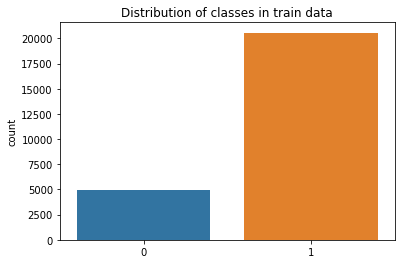

In [ ]:
sns.countplot(y_train)
plt.title("Distribution of classes in train data")
plt.show()

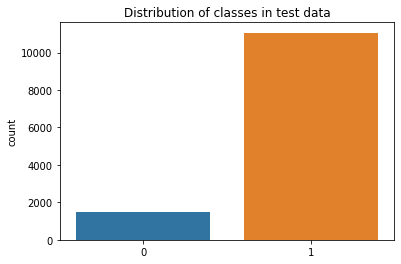

In [ ]:
sns.countplot(y_test)
plt.title("Distribution of classes in test data")
plt.show()

The distribution of classes is similar in both train and test data.

### Modelling

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_train=model.predict(X_train)

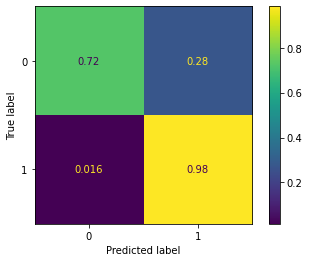

In [ ]:
#confusion matrxi for train data
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train,normalize="true") 

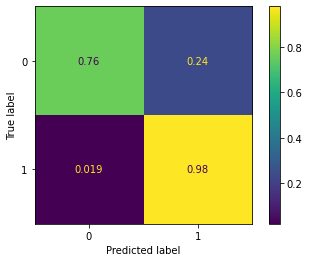

In [ ]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,normalize="true") 

**OBSERVATIONS FROM THE LOGISTIC REGRESSION MODEL WITHOUT DATA BALANCING**

We can see that through augmnetation, the performance of the model on negative reviews has improved. 

Now let's check the performance of the model using data balancing

In [ ]:
model=LogisticRegression(class_weight="balanced")
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

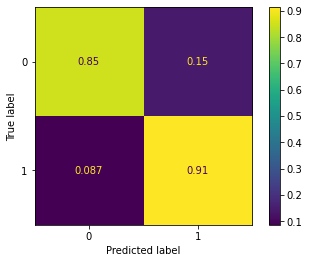

In [ ]:
#confusion matrxi for train data
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train,normalize="true") 

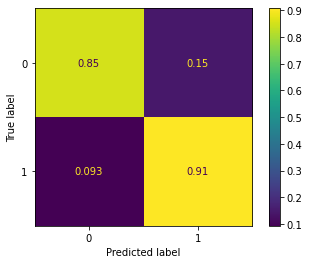

In [ ]:
#confusion matrix for test data
sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,normalize="true") 

**Observations from logistic regression model:** We can see that the performance is highly improved when we balance the classes after augmentation in the text data. 

**Model 3-- XGBOOST**

In [ ]:
import xgboost
from xgboost import XGBClassifier

In [ ]:
model3=XGBClassifier()


### Hyper parameter tuning of the model



In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:

max_depth=[1,2,4,6]
n_estimators=[10,50,100,150,200]
params = {'max_depth': [1,2,4,6],'n_estimators': [10,50,100,150,200]}
best_model=GridSearchCV(model3,params,cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1,verbose=1)

In [ ]:
best_model.fit(X_train,y_train) 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 66.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_tra

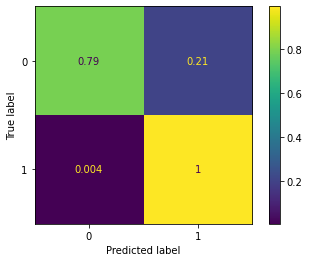

In [ ]:
sklearn.metrics.plot_confusion_matrix(best_model, X_train, y_train,normalize="true") 

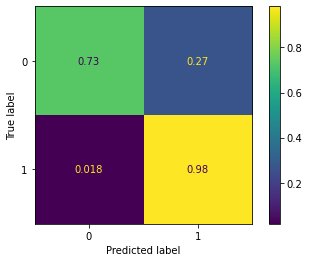

In [ ]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(best_model, X_test, y_test,normalize="true") 

**OBSERVATION**

This model performed better than Logistic Regression model without balancing the data. Also, we can see that the predictions of negative reviews has improved due to the character and word augmentations. Now let us see if perfomance improve more with balanced data

Upsampling of negative reviews

In [ ]:
from sklearn.utils import resample
df_majority = final_df[final_df.y==1]
df_minority = final_df[final_df.y==0]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=df_majority.shape[0],random_state=123) # reproducible results
# Combine majority class with upsampled minority class
data_balanced = pd.concat([df_majority, df_minority_upsampled])
# Display new class counts
data_balanced.y.value_counts()

1    31629
0    31629
Name: y, dtype: int64

In [ ]:
#train_test split
data_balanced=data_balanced.sort_values(by="dates")
 
train, test= np.split(data_balanced, [int(.67 *len(data_balanced))])

In [ ]:
print(train.shape)
print(test.shape)

(42382, 5)
(20876, 5)


In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# maximum number of tokens is 70(We already given this to BERT layer above) so shape is (None, 70)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 70) save those in X_train_mask, X_test_mask
# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 70)
# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment


X_train_tokens=[]
X_train_mask=[]
X_train_segment=[]
for text in (train["reviews"]):
  # add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 
  tokens= ["[CLS]",*tokenizer.tokenize(text)[:68],"[SEP]"]
  if len(tokenizer.tokenize(text))<68:
    X_train_mask.append(np.array([1]*len(tokens)+[0]*(70-len(tokens))))
  else:
    X_train_mask.append(np.array([1]*70))

  if len(tokens)<70:
    # if length of token is less than 70, add '[PAD]' token else truncate the tokens length.(similar to padding)
    for i in range(70-len(tokens)):
      tokens+=["[PAD]"]
  ids=np.array(tokenizer.convert_tokens_to_ids(tokens))
  X_train_tokens.append(ids)

  X_train_segment.append(np.array([0]*70))
X_train_tokens=np.array(X_train_tokens)
X_train_mask=np.array(X_train_mask)
X_train_segment=np.array(X_train_segment)

X_test_tokens=[]
X_test_mask=[]
X_test_segment=[]
for text in test["reviews"]:
  # add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 
  token=["[CLS]",*tokenizer.tokenize(text)[:68],"[SEP]"]
  
  if len(tokenizer.tokenize(text))<68:
    # if it is less than 70, add '[PAD]' token else truncate the tokens length.(similar to padding)
    X_test_mask.append(np.array([1]*len(token)+[0]*(70-len(token))))
  else:
    X_test_mask.append(np.array([1]*70))

  if len(token)<70:
    for i in range(70-len(token)):
      token+=["[PAD]"]
  id=np.array(tokenizer.convert_tokens_to_ids(token))
  X_test_tokens.append(id)

  X_test_segment.append(np.array([0]*70))

X_test_tokens=np.array(X_test_tokens)
X_test_mask=np.array(X_test_mask)
X_test_segment=np.array(X_test_segment)


In [ ]:
print(X_train_tokens.shape)
print(X_train_mask.shape)

(42382, 70)
(42382, 70)


In [ ]:
#obtaining featurization
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])


In [ ]:
print(X_train_pooled_output.shape)
print(X_test_pooled_output.shape)

(42382, 768)
(20876, 768)


In [ ]:
#now we merge the text features, polarity and do.recommend feature into x


X_train=np.hstack((X_train_pooled_output,train["polarity"].values.reshape(-1,1),train["reviews.doRecommend"].values.reshape(-1,1)))
X_test=np.hstack((X_test_pooled_output,test["polarity"].values.reshape(-1,1),test["reviews.doRecommend"].values.reshape(-1,1)))
y_train=train["y"].values
y_test=test["y"].values
print(X_train.shape)
print(X_test.shape)

(42382, 770)
(20876, 770)


In [ ]:
max_depth=[1,2,4,6]
n_estimators=[10,50,100,150,200]
params = {'max_depth': [1,2,4,6],'n_estimators': [10,50,100,150,200]}
best_model=GridSearchCV(model3,params,cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1,verbose=1)

In [ ]:
best_model.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 87.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_tra

In [ ]:
model3=XGBClassifier()
model3.fit(X_train,y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

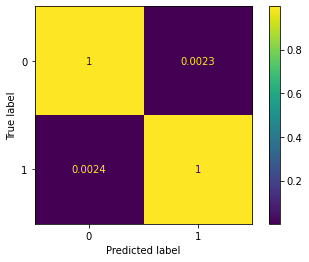

In [ ]:
#confusion matrxi for train data
sklearn.metrics.plot_confusion_matrix(model3, X_train, y_train,normalize="true") 

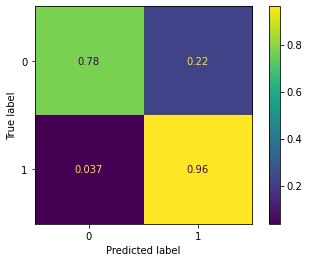

In [ ]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(best_model, X_test, y_test,normalize="true") 

In [ ]:
y_test_hat=best_model.predict(X_test)

In [ ]:
import random
idx=random.sample(range(test.shape[0]),100)
for i in idx:
  if test.iloc[i]["y"]==0 and y_test_hat[i]==1:
    print(test.iloc[i]["reviews"])
    
    print("*"*100)
    

like everything work big needs been like needs work product 'd not everything lot questions not user friend item limited things money needs thinking work expecting more store most
****************************************************************************************************
not great start not great start not great start first bought got started would not register amazon account tried making new account tried using moms account would not work took back geek squad look claimed defective exchanged another one new one works wonderfully not issues yet 
****************************************************************************************************
indeed produce great product great product great device use weekday basis good investment
****************************************************************************************************
limited options limited options limited options you though plays playlist be time
*****************************************************************

**OBSERVATIONS FROM MODEL 3:**

This model and this featurization outperformed all the previous techniques

This has a little overfitting when coming to the negative reviews. We can see that, the training data is perfectly classified. But there is still some misclassification for negative reviews in test data. 

However, the test performance is also good, when comapred to other models

**OBSERVATIONS AND CONCLUSIONS**

We can see that the misclassified reviews are mainly neural reviews. These are given rating of 3, but were included along negative reviews. In some reviews we can see that the product is nice, but there are some limitations. So the model incorrectly classified the product review as positive. If we ignore all the neutral reviews, we will obtain better results. But the number of negative reviews will further reduce and this will cause data balancing issues